In [1]:

import itertools

import numpy as np
import matplotlib.pyplot as plt

from thinkstats2 import Cdf
from thinkstats2 import RandomSeed

import thinkplot

# Fitness Landscape

In [2]:
class FitnessLandscape:
    
    def __init__(self, N):
        """Create a fitness landscape.
        
        N: number of dimensions
        """
        self.N = N
        self.set_values()
        
    def set_values(self):
        self.one_values = np.random.random(self.N)
        self.zero_values = np.random.random(self.N)
        
    def random_loc(self):
        """Choose a random location"""
        return np.random.randint(2, size=self.N, dtype=np.int8)
    
    def fitness(self, loc):
        """Evaluates the fitness of a location.
        
        loc: array of N 0s and 1s
        
        returns: float fitness
        """
        fs = np.where(loc, self.one_values, self.zero_values)
        return fs.mean()
    
    def distance(self, loc1, loc2):
        return np.sum(np.logical_xor(loc1, loc2))        

In [3]:
fit_land = FitnessLandscape(3)
fit_land.N

3

In [4]:
fit_land.one_values, fit_land.zero_values

(array([0.74103744, 0.14819699, 0.03558991]),
 array([0.00090095, 0.31765119, 0.89187765]))

In [5]:
loc = fit_land.random_loc()
loc

array([1, 1, 1], dtype=int8)

In [6]:
a = np.where(loc, fit_land.one_values, fit_land.zero_values)
a, np.mean(a)

(array([0.74103744, 0.14819699, 0.03558991]), 0.3082747789559193)

In [7]:
loc, fit_land.fitness(loc)

(array([1, 1, 1], dtype=int8), 0.3082747789559193)

In [8]:
loc1 = fit_land.random_loc()
loc2 = fit_land.random_loc()
print(loc1)
print(loc2)
fit_land.distance(loc1, loc2)

[0 0 0]
[1 0 1]


2

In [9]:
np.logical_xor(loc1, loc2)

array([ True, False,  True])

# The Agents

In [10]:
class Agent:
    """Represents an agent in an NK model"""
    
    def __init__(self, loc, fit_land):
        """Create an agent at the given location.
        
        loc: array of N 0s and 1s
        fit_land: reference to an fit_land
        """
        self.loc = loc
        self.fit_land = fit_land
        self.fitness = fit_land.fitness(self.loc)
        
    def copy(self):
        return Agent(self.loc, self.fit_land)

In [11]:
loc = fit_land.random_loc()
agent = Agent(loc, fit_land)
agent.loc, agent.fitness

(array([1, 1, 0], dtype=int8), 0.5937040261546364)

# The Simulator

In [12]:
class Simulation:
    def __init__(self, fit_land, agents):
        """Create the simulation:
        
        fit_land: fit_land
        num_agents: int number of agents
        agent_maker: function that makes agents
        """
        self.fit_land = fit_land
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def add_instrument(self, instrument):
        """Adds an instrument to the list.
        
        instrument: instrument object
        """
        self.instruments.append(instrument)
        
    def plot(self, index, *args, **kwargs):
        """Plot the results from the indicated instrument.
        """
        self.instruments[index].plot(*args, **kwargs)
        
    def run(self, num_steps=500):
        """Run the given number of steps.
        
        num_steps: integer
        """
        # initialize any instruments before starting
        self.update_instruments()
        
        for _ in range(num_steps):
            self.step()
            
    def step(self):
        """Simulate a time step and update the instruments.
        """
        n = len(self.agents)
        fits = self.get_fitnesses()
        
        # see who dies
        index_dead = self.choose_dead(fits)
        num_dead = len(index_dead)
        
        # replace the dead with copies of the living
        replacements = self.choose_replacements(num_dead, fits)
        self.agents[index_dead] = replacements
        
        # update any instruments
        self.update_instruments()
        
    def update_instruments(self):
        for instrument in self.instruments:
            instrument.update(self)
            
    def get_locs(self):
        """Returns a list of agent locations."""
        return [tuple(agent.loc) for agent in self.agents]
    
    def get_fitnesses(self):
        """Returns an array of agent fitnesses."""
        fits = [agent.fitness for agent in self.agents]
        return np.array(fits)
    
    def choose_dead(self, ps):
        """choose which agents die in the next timestep.
        
        ps: probability of survival for each agent
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) < 0.1
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
    
    def choose_replacements(self, n, weights):
        """choose which agents reproduce in thenext timestep.
        
        n: number of choices
        weights: array of weights
        
        returns: sequence of Agent objects
        """
        agents = np.random.choice(self.agents, size=n, replace=True)
        replacements = [agent.copy() for agent in agents]
        return replacements        

In [13]:
def make_identical_agents(fit_land, num_agents, agent_maker):
    """Make an array of Agents.
    
    fit_land: FitnessLandscape
    num_agents: integer
    agent_maker: class used to make Agent
    
    returns: array of Agents
    """
    loc = fit_land.random_loc()
    agents = [agent_maker(loc, fit_land) for _ in range(num_agents)]
    return np.array(agents)

In [14]:
def make_random_agents(fit_land, num_agents, agent_maker):
    """Make an array of Agents.
    
    fit_land: FitnessLandscape
    num_agents: integer
    agent_maker: class use to make Agent
    
    returns: arrayof Agents
    """
    locs = [fit_land.random_loc() for _ in range(num_agents)]
    agents = [agent_maker(loc, fit_land) for loc in locs]
    return np.array(agents)

In [15]:
def make_all_agents(fit_land, agent_maker):
    """Make an array of Agents.
    
    fit_land: FitnessLandscape
    agent_maker: class used to make Agent
    
    returns: array of Agents
    """
    N = fit_land.N
    locations = itertools.product([0, 1], repeat=N)
    agents = [agent_maker(loc, fit_land) for loc in locations]
    return np.array(agents)

In [16]:
fit_land = FitnessLandscape(3)
agents = make_all_agents(fit_land, Agent)
for agent in agents:
    print(agent.loc, agent.fitness)

(0, 0, 0) 0.3564478455972621
(0, 0, 1) 0.4580102697033823
(0, 1, 0) 0.5491916234524887
(0, 1, 1) 0.650754047558609
(1, 0, 0) 0.30713061111168194
(1, 0, 1) 0.40869303521780215
(1, 1, 0) 0.4998743889669086
(1, 1, 1) 0.6014368130730289


## The distribution of fitness

In [17]:
RandomSeed(17)
N = 8
fit_land = FitnessLandscape(N)
agents = make_all_agents(fit_land, Agent)
sim = Simulation(fit_land, agents)

In [18]:
def plot_fitnesses(sim):
    """Plot the CDF of fitnesses.
    
    sim: Simulation object
    """
    fits = sim.get_fitnesses()
    cdf_fitness = Cdf(fits)
    thinkplot.Cdf(cdf_fitness)
    return np.mean(fits)

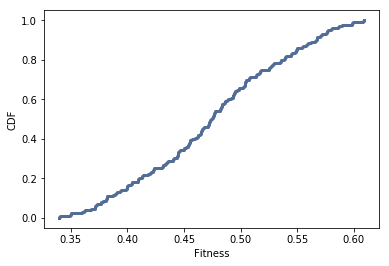

In [19]:
prop = dict(xlabel='Fitness', ylabel='CDF')
plot_fitnesses(sim)
thinkplot.config(**prop)

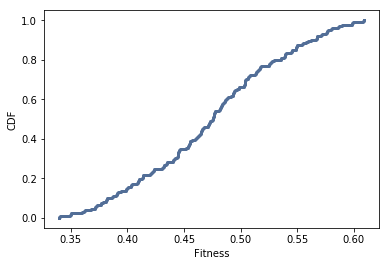

In [20]:
sim.step()
plot_fitnesses(sim)
thinkplot.config(**prop)

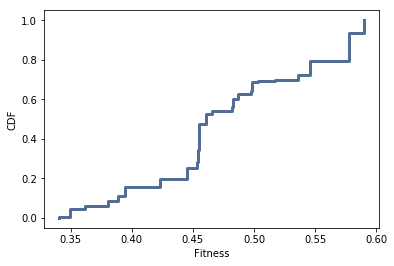

In [21]:
sim.run(100)
plot_fitnesses(sim)
thinkplot.config(**prop)

## Instruments

In [22]:
class Instrument:
    """Computes a metric at each timestep."""
    
    def __init__(self):
        self.metrics = []
        
    def update(self, sim):
        """Compute the current metric.
        
        Appends to self.metrics.
        
        sim: Simulation object
        """
        # child classes should implement this method
        pass
    
    def plot(self, **options):
        thinkplot.plot(self.metrics, **options)

In [23]:
class MeanFitness(Instrument):
    """Computes the mean fitness at each timestep."""
    label = 'Mean fitness'
    
    def update(self, sim):
        mean = np.nanmean(sim.get_fitnesses())
        self.metrics.append(mean)

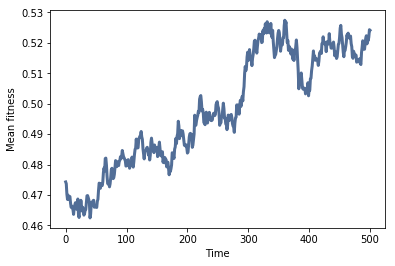

In [24]:
RandomSeed(17)
N=8
fit_land = FitnessLandscape(N)
agents = make_all_agents(fit_land, Agent)

sim = Simulation(fit_land, agents)
instrument = MeanFitness()
sim.add_instrument(instrument)
sim.run(500)
sim.plot(0)

thinkplot.config(xlabel='Time', ylabel='Mean fitness')

In [25]:
def plot_sims(fit_land, agent_maker, sim_maker, instrument_maker, **plot_options):
    """Runs simulations and plots metrics.
    
    fit_land: FitnessLandscape
    agent_maker: function that makes an array of Agents
    sim_maker: function that makes a Simulation
    instrument_maker: function that makes an instrument
    plot_options: passes along to plot
    """
    plot_options['alpha'] = 0.3
    
    for _ in range(10):
        agents = agent_maker(fit_land)
        sim = sim_maker(fit_land, agents)
        instrument = instrument_maker()
        sim.add_instrument(instrument)
        sim.run()
        sim.plot(0, **plot_options)
    thinkplot.config(xlabel='Time', ylabel=instrument.label)
    return sim

In [26]:
def agent_maker1(fit_land):
    return make_all_agents(fit_land, Agent)

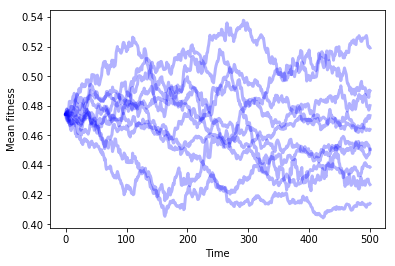

In [27]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, Simulation, MeanFitness, color='blue')

# DifferentialSurvival

In [28]:
class SimWithDiffSurvival(Simulation):
    
    def choose_dead(self, ps):
        """Choose which agents die in the next timestep.
        
        ps: probability of survival for each agent
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) > ps
        index_dead = np.nonzero(is_dead)[0]
        return index_dead

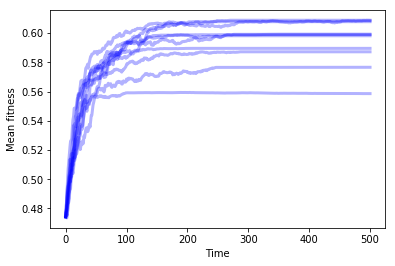

In [29]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, SimWithDiffSurvival, MeanFitness, color='blue')

In [30]:
class SimWithDiffReproduction(Simulation):
    
    def choose_replacements(self, n, weights):
        """choose which agents reproduce in the next timestep.
        
        n: number of choices
        weights: array of weights
        
        returns: sequence of agent objects
        """
        p = weights / np.sum(weights)
        agents = np.random.choice(self.agents, size=n, replace=True, p=p)
        replacements = [agent.copy() for agent in agents]
        return replacements

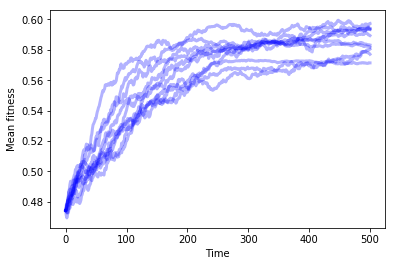

In [31]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, SimWithDiffReproduction, MeanFitness, color='blue')
None

In [32]:
class SimWithBoth(Simulation):
    
    def choose_dead(self, ps):
        """Choose which agents die in the next timestep.
        
        ps: probability of survival for each agent
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) > ps
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
    
    def choose_replacements(self, n, weights):
        """choose which agents reproduce in the next timestep.
        
        n: number of choices
        weights: array of weights
        
        returns: sequence of agent objects
        """
        p = weights / np.sum(weights)
        agents = np.random.choice(self.agents, size=n, replace=True, p=p)
        replacements = [agent.copy() for agent in agents]
        return replacements

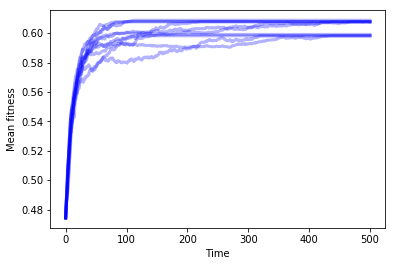

In [33]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, SimWithBoth, MeanFitness, color='blue')
None

In [34]:
class OccupiedLocations(Instrument):
    label = 'Occupied locations'
    
    def update(self, sim):
        uniq_agents = len(set(sim.get_locs()))
        self.metrics.append(uniq_agents)

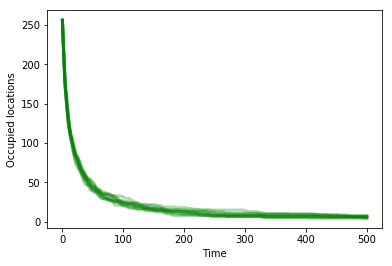

In [35]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, Simulation, OccupiedLocations, color='green')
None

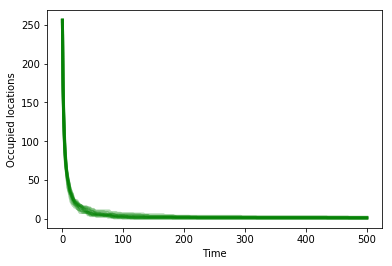

In [36]:
RandomSeed(17)
plot_sims(fit_land, agent_maker1, SimWithBoth, OccupiedLocations, color='green')
None

# Mutation

In [37]:
class Mutant(Agent):
    
    def copy(self, prob_mutate=0.05):
        if np.random.random() > prob_mutate:
            loc = self.loc.copy()
        else:
            direction = np.random.randint(self.fit_land.N)
            loc = self.mutate(direction)
        return Mutant(loc, self.fit_land)
    
    def mutate(self, direction):
        """Computes the location in the given location.
        
        Result differs from the current location along the given axis.
        
        direction: int index from 0 to N-1
        
        returns: new array of N 0s and 1s
        """
        new_loc = self.loc.copy()
        new_loc[direction] ^= 1
        return new_loc

In [38]:
N = 8
fit_land = FitnessLandscape(N)
loc = fit_land.random_loc()
agent = Mutant(loc, fit_land)
agent.loc

array([0, 0, 0, 1, 1, 1, 0, 0], dtype=int8)

In [39]:
for i in range(20):
    copy = agent.copy()
    print(fit_land.distance(agent.loc, copy.loc))

0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
0
0
0
0


In [81]:
def agent_maker2(fit_land):
    agents = make_identical_agents(fit_land, 100, Mutant)
    return agents

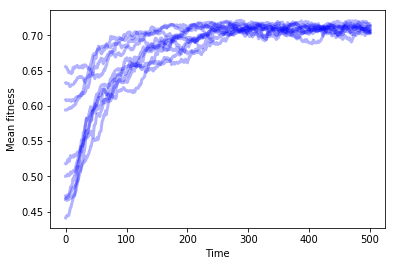

In [82]:
RandomSeed(17)
sim = plot_sims(fit_land, agent_maker2, SimWithBoth, MeanFitness, color='blue')

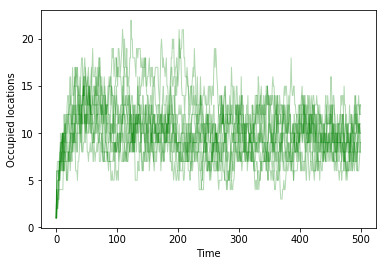

In [84]:
RandomSeed(17)
sim = plot_sims(fit_land, agent_maker2, SimWithBoth, OccupiedLocations,
               color='green', linewidth=1)

In [85]:
class MeanDistance(Instrument):
    """Computes mean distance between pairs at each timestep"""
    label = 'Mean distance'
    
    def update(self, sim):
        N = sim.fit_land.N
        i1, i2 = np.triu_indices(N)
        agents = zip(sim.agents[i1], sim.agents[i2])
        
        distances = [fit_land.distance(a1.loc, a2.loc)
                    for a1, a2 in agents if a1 != a2]
        
        mean = np.mean(distances)
        self.metrics.append(mean)

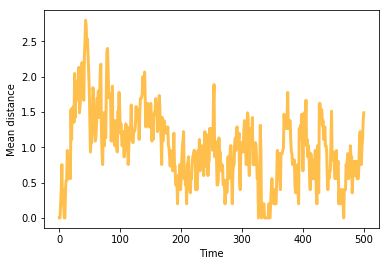

In [86]:
RandomSeed(17)

fit_land = FitnessLandscape(10)
agents = make_identical_agents(fit_land, 100, Mutant)
sim = SimWithBoth(fit_land, agents)
sim.add_instrument(MeanDistance())
sim.run(500)
sim.plot(0, color='orange')
thinkplot.Config(xlabel='Time', ylabel='Mean distance')

In [87]:
RandomSeed(17)

fit_land = FitnessLandscape(10)
agents = make_identical_agents(fit_land, 100, Mutant)
sim = SimWithBoth(fit_land, agents)
sim.add_instrument(MeanFitness())
sim.add_instrument(OccupiedLocations())
sim.add_instrument(MeanDistance())
sim.run(500)
locs_before = sim.get_locs()
fit_land.set_values()
sim.run(500)
locs_after = sim.get_locs()

In [88]:
vline_options = dict(color='gray', linewidth=3, alpha=0.5)

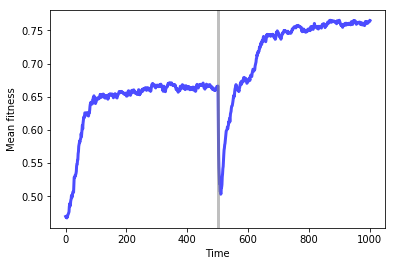

In [89]:
sim.plot(0, color='blue')
thinkplot.axvline(500, **vline_options)
thinkplot.Config(xlabel='Time', ylabel='Mean fitness')

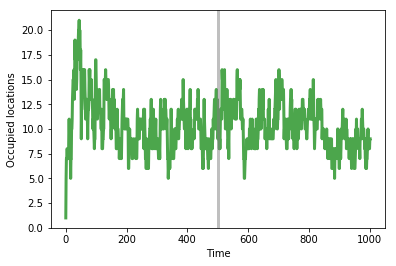

In [90]:
sim.plot(1, color='green')
thinkplot.axvline(500, **vline_options)
thinkplot.Config(xlabel='Time', ylabel='Occupied locations')

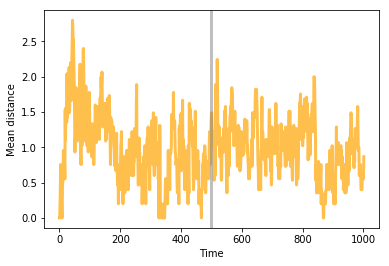

In [91]:
sim.plot(2, color='orange')
thinkplot.axvline(500, **vline_options)
thinkplot.Config(xlabel='Time', ylabel='Mean distance')

In [92]:
distances = []
for loc1 in locs_before:
    for loc2 in locs_after:
        distances.append(fit_land.distance(loc1, loc2))
np.mean(distances)

6.3948

# Exercises

## 11.2

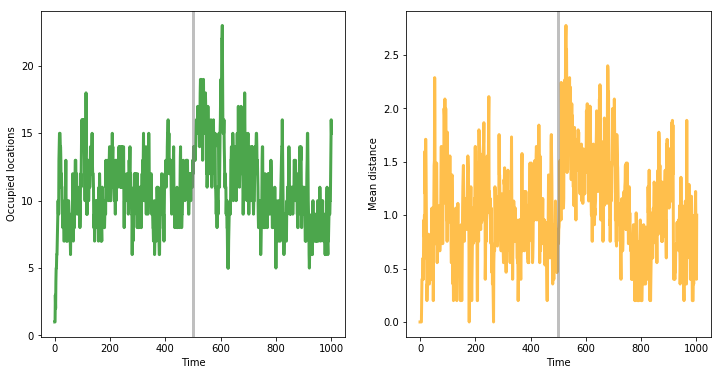

In [97]:
RandomSeed(5)

fit_land = FitnessLandscape(10)
agents = make_identical_agents(fit_land, 100, Mutant)
sim = SimWithBoth(fit_land, agents)
sim.add_instrument(MeanFitness())
sim.add_instrument(OccupiedLocations())
sim.add_instrument(MeanDistance())
sim.run(500)
locs_before = sim.get_locs()
fit_land.set_values()
sim.run(500)
locs_after = sim.get_locs()

vline_options = dict(color='gray', linewidth=3, alpha=0.5)

thinkplot.preplot(cols=2)
sim.plot(1, color='green')
thinkplot.axvline(500, **vline_options)
thinkplot.Config(xlabel='Time', ylabel='Occupied locations')

thinkplot.subplot(2)
sim.plot(2, color='orange')
thinkplot.axvline(500, **vline_options)
thinkplot.Config(xlabel='Time', ylabel='Mean distance')